# ZILLOW PROJECT
## Predicting the tax value of single family homes in the Los Angeles area

## Project Description

This Jupyter Notebook and presentation explore the Zillow dataset from the Codeup database. The data used relates to 2017 real estate transactions relating to single family homes in three California counties, and different aspects of the properties. An part aspect of the Zillow business model is to be able to publish accurate home values; I intend to build a machine learning model that makes predictions about the tax value of the homes in question.


## Project Goals

The ultimate goal of this project is to build a model that predicts the tax value of these homes with a higher accuracy than the baseline I have chosen. I will use Residual Mean Square Error as my metric for evaluation, and many models will be built using different features and hyperparameters to find the model of best fit.

The final deliverable will be the RMSE value resulting from my best model, contrasted with the baseline RMSE.

Additionally, a Jupyter Notebook and presentation with my main findings and conclusions will be a key deliverable; many .py files will exist as a back-up to the main Notebook (think "under-the-hood" coding that will facilitate the presentation).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
from scipy import stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
# importing my personal wrangle module
import wrangle
import explore
import model
import viz

In [2]:
# Acquiring the data using the wrangle
zillow_sql_query = wrangle.get_zillow_data()
# I am working with a copy of the SQL query to be able to access it faster
zillow = zillow_sql_query.copy()

In [3]:
# Using my wrangle module to clean and prep the data. NaNs are dropped; so are outliers. 
# An 'age' column has been added
# The yearbuilt column was deleted
# No outliers were removed from year built, age, or fips; they were removed from all other features
zillow = wrangle.clean_and_prep_data(zillow)

In [4]:
zillow.head()

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom
0,4.0,3.5,3100.0,1023282.0,Orange,23,885.714286
1,2.0,1.0,1465.0,464000.0,Ventura,54,1465.000000
2,3.0,2.0,1243.0,564778.0,Orange,59,621.500000
3,4.0,3.0,2376.0,145143.0,LA,51,792.000000
4,4.0,3.0,2962.0,773303.0,LA,71,987.333333


In [5]:
# my clean_and_prep function is cutting down the size here by 
# dropping NaNs and removing outliers--the majority of the rows dropped were outliers.
zillow.shape, zillow_sql_query.shape

((44864, 7), (52442, 7))

## Initial data exploration:

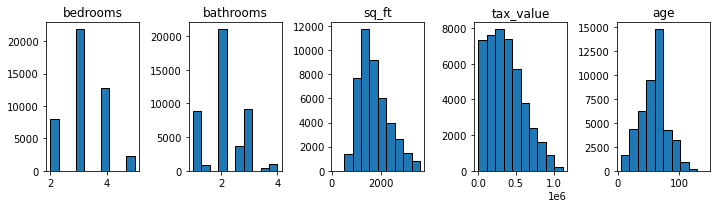

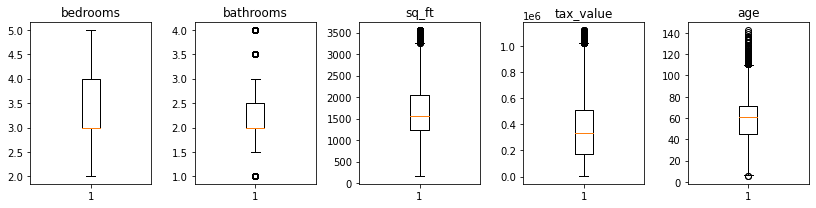

In [6]:
# Here, we create a for loop that makes a histogram for every column. This is the start of my univariate analysis

plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms','sq_ft','tax_value', 'age']
# Note the enumerate code, which is functioning to make a counter for use in successive plots.

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,8, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    zillow[col].hist(bins=10, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)
    
    plt.tight_layout()
    
,

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,7, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    plt.boxplot(zillow[col])
    
    # Hide gridlines.
    plt.grid(False)
    
    plt.tight_layout()

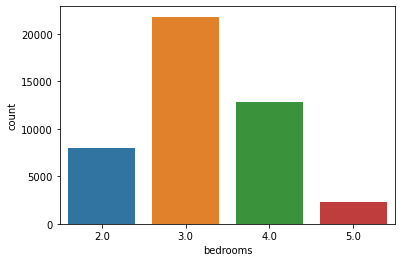

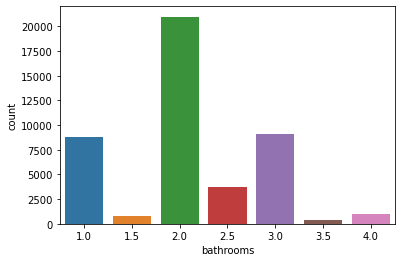

In [7]:
disc_vars = ['bedrooms','bathrooms']
for var in disc_vars:
    plt.figure()
    sns.countplot(x=var,data=zillow)

In [8]:
# Describe was displaying with scientific notation, so I rounded to 2 places.  
round(zillow.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
bedrooms,44864.0,3.21,0.79,2.0,3.0,3.0,4.0,5.0
bathrooms,44864.0,2.09,0.72,1.0,2.0,2.0,2.5,4.0
sq_ft,44864.0,1694.01,605.61,152.0,1238.0,1568.0,2050.0,3566.0
tax_value,44864.0,363580.89,233629.59,1000.0,171473.0,331368.0,511394.0,1122409.0
age,44864.0,58.98,21.62,5.0,45.0,61.0,71.0,143.0
sq_ft_per_bathroom,44864.0,840.16,227.00,76.0,683.0,803.0,955.0,3438.0


In [9]:
# This cell utilizes a function in my wrangle.py to encode the fips (renamed 'county')
encoded = wrangle.encode_zillow(zillow)

# SPLITTING

In [10]:
# Wrangle.py has a function to split the data into train, validate and test sets
# Additionally, I have split further in X_ and y_ sets for train, validate and test respectively
train, validate, test,X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_zillow(encoded)

# SCALING
### I've done it in this order so I can explore different data sets as is appropriate

In [11]:
# Wrangly.py also has a function to scale my data
# I saved these to different variables so I could use the exact data set for different analyes
train_scaled, X_train_scaled, y_train_scaled, \
validate_scaled, X_validate_scaled, y_validate_scaled, \
test_scaled, X_test_scaled, y_test_scaled = wrangle.scale_zillow(train, validate, test)

### Takeaway: LA county has slightly older homes that have kept their value more than homes in the other counties. Please note the left skew of Orange and Ventura counties (compared to LA)

# DATA EXPLORATION--BIVARIATE AND MULTIVARIATE

### I relied on an unencoded version of the data set for some of my visual exploration.

<AxesSubplot:xlabel='county', ylabel='tax_value'>

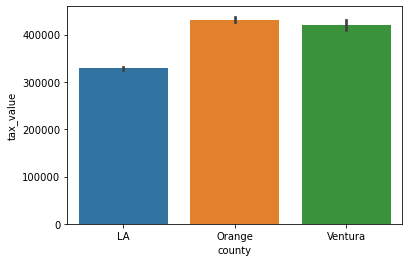

In [12]:
# Here, we see a seaborn barplot of the average tax value in each county
sns.barplot(x=train.county, y=train.tax_value)

<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

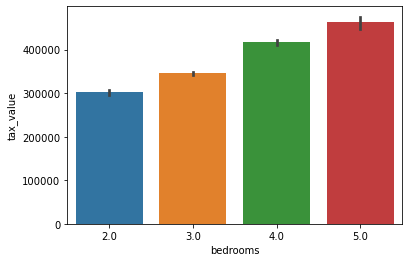

In [13]:
# A seaborn barplot of number of bedrooms and tax value
sns.barplot(x=train.bedrooms, y=train.tax_value)

<AxesSubplot:xlabel='bathrooms', ylabel='tax_value'>

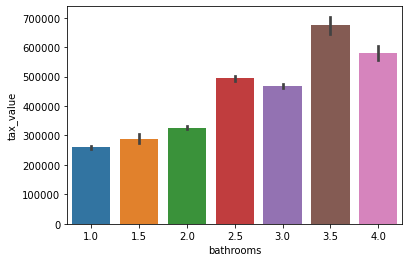

In [14]:
# And a seaborn barplot of bathrooms vs. tax value
sns.barplot(x=train.bathrooms, y=train.tax_value)

### There might be some houses with too many bathrooms.

<AxesSubplot:>

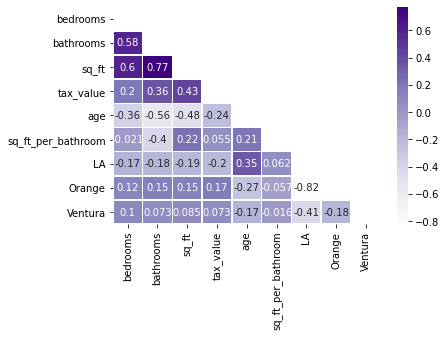

In [15]:
# This code is creating a variable holding the correlations of the different variable between each other
train_corr = train.corr()
# And here, we use the variable to draw up a seaborn heatmap for a better visual
sns.heatmap(train_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(train_corr))

### This heatmap is what inspired me to take a look at the square feet per bathroom, which you saw above as an added feature; I do further exploration immediately below.

<AxesSubplot:xlabel='bathrooms', ylabel='sq_ft'>

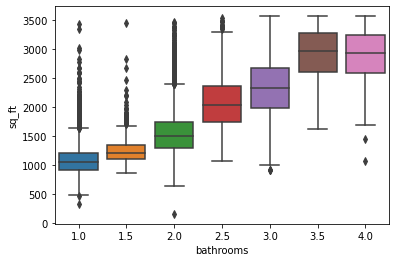

In [16]:
sns.boxplot(x='bathrooms', y='sq_ft', data=train)

In [17]:
# Here, I use boolean masking to create variables holding only those houses with 2 bathrooms, for example, or 1 or 3
baths_2 = train[train.bathrooms == 2.00].sq_ft
baths_1 = train[train.bathrooms == 1.00].sq_ft
baths_3 = train[train.bathrooms == 3.00].sq_ft
baths_2_5 = train[train.bathrooms == 2.50].sq_ft
baths_4 = train[train.bathrooms == 4.00].sq_ft
baths_1_5 = train[train.bathrooms == 1.50].sq_ft
baths_3_5 = train[train.bathrooms == 3.50].sq_ft

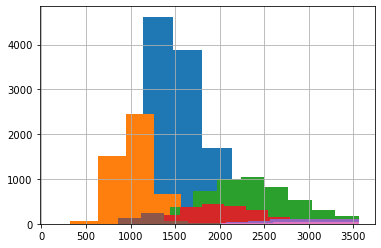

In [18]:
# The for loop below shows the histogram of each 'bathroom category' using matplotlib
# I needed to check the variables for their 'normality' to proceed to stats testing below
baths_list = [baths_2, baths_1, baths_3, baths_2_5,baths_4,baths_1_5,baths_3_5]

for bath in baths_list:
    plt.figure
    bath.hist();

In [19]:
# check variances
for bath in baths_list:
    print(bath.var())
# they differ

115053.3907628811
73232.96691576087
237156.8394624062
193107.49698562815
200717.34732485522
74290.53161074709
201218.9193462751


Set Hypothesis
- 𝐻0 : Population means of sq_ft (by bathrooms) counts are equal
- 𝐻𝑎 : Population means of sq_ft (by bathrooms) are not all equal

In [20]:
# This cell runs an ANOVA test on the different 'bathroom categories'
# We are demonstrating statistically that the number of bathrooms correlates to the square footage
f, p = stats.f_oneway(baths_2, baths_1, baths_3, baths_2_5,baths_4,baths_1_5,baths_3_5)
f, p

(6818.1000019266785, 0.0)

In [21]:
alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We reject H_O


### The ANOVA test shows that we can procede with the understanding that more square feet correlates with a higher number of bathrooms; I have added a square feet per bathroom feature to the dataset in my wrangle.py for further exploration below.

## Research question number 1: 

Are bigger houses valued higher?

<AxesSubplot:title={'center':'There seems to be a positive correlation between square feet and tax_value'}, xlabel='sq_ft', ylabel='tax_value'>

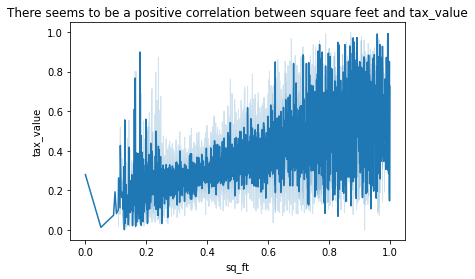

In [22]:
# This cell creates a seaborn lineplot--it's not the best plot for the data, per se,
# but creates a good visual to demonstrate the relationship
plt.title('There seems to be a positive correlation between square feet and tax_value')
sns.lineplot(x=train_scaled.sq_ft, y=train_scaled.tax_value)#,markers=True)

### In the following cells, we will establish statistically the relationship:

Hypothesis testing: 

    H_o: Square feet and tax_value are not related
    H_a: Square feet and tax_value are related
    

In [23]:
alpha = 0.05

corr, p = stats.pearsonr(train.sq_ft, train.tax_value)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p

We reject the null hypothesis


(0.4335428740580575, 0.0)

### There is statistical evidence of a moderate correlation between the variables, and I will proceed with this understanding.

## Research question number 2: what are some of the other aspects of higher-tax value homes:

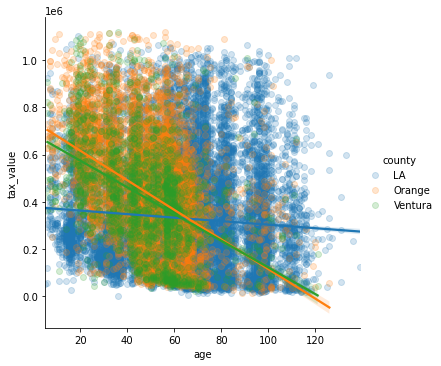

In [24]:
# I created a seaborn lmplot here to show the relationship between age and tax value
# The chart is drawn using 'county' as the hue
sns.lmplot(x='age', y='tax_value', data=train, scatter_kws={'alpha':.2},hue='county')#line_kws={'color': 'red'},

### Takeaway: newer homes are valued higher--but the correlation is weaker in LA county

## Research question number 3: Newer homes are larger; they are also valued more highly. Is there an exception to the rule?


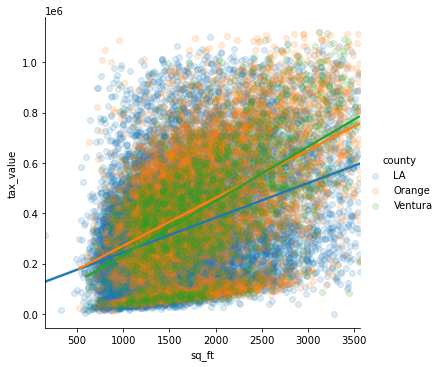

In [25]:
sns.lmplot(x='sq_ft',y='tax_value',data=train, hue= 'county',scatter_kws={'alpha':.15})

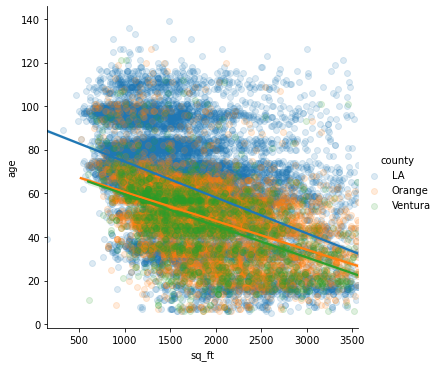

In [26]:
sns.lmplot(x='sq_ft',y='age',data=train, hue= 'county',scatter_kws={'alpha':.15})

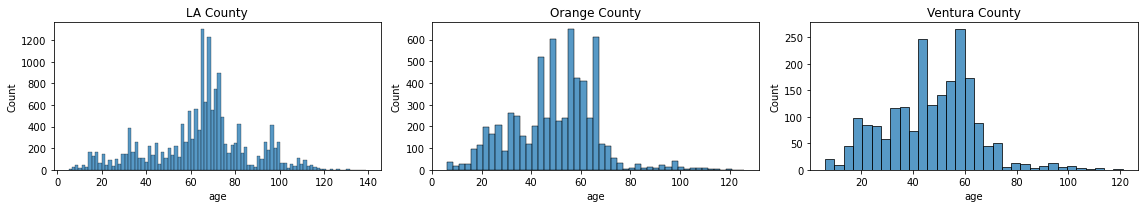

In [27]:
plt.figure(figsize = (16,3))
plt.subplot(1,3, 1)

# Title with column name.
plt.title('LA County')
# Display histogram for column.
#plt.boxplot(train[col])
sns.histplot(data=train[train.county=='LA'].age)
# Hide gridlines.

plt.subplot(1,3, 2)
# Title with column name.
plt.title('Orange County')
# Display histogram for column.
#plt.boxplot(train[col])
sns.histplot(data=train[train.county=='Orange'].age)
# Hide gridlines.

plt.subplot(1,3, 3)
# Title with column name.
plt.title('Ventura County')
# Display histogram for column.
#plt.boxplot(train[col])
sns.histplot(data=train[train.county=='Ventura'].age)
# Hide gridlines.

plt.grid(False)
plt.tight_layout()

### Takeaways: 
- LA county has slightly older homes that have kept their value more than homes in the other counties. Please note the right skew of Orange and Ventura counties (compared to LA)
- Older homes in LA county don't depreciate as much as in the other counties; nevertheless, larger homes still have a higher tax value there.  

## Research question number 4: is there a relationship between the sq_ft_per_bathroom and value?

<AxesSubplot:xlabel='bathrooms', ylabel='tax_value'>

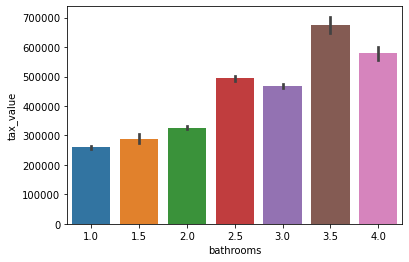

In [28]:
# And a seaborn barplot of bathrooms vs. tax value
sns.barplot(x=train.bathrooms, y=train.tax_value)

### It's clear that more bathrroms correlate with higher tax value (see also the heatmap above).  

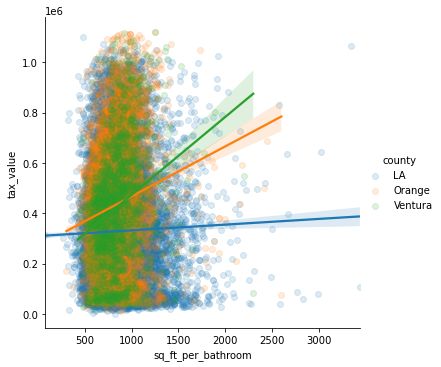

In [29]:
sns.lmplot(x='sq_ft_per_bathroom',y='tax_value',data=train, hue= 'county',scatter_kws={'alpha':.15})

## Takeaway: sfpb has less impact on tax value in LA county than in the other two counties.  This is evidence that two models could be handy (LA county vs. the other two)

## I'm also of the opinion that having a half bath might be correlated to higher tax value as well, which would be a feature to pursue for further research

### I am conducting a pearson-r below to back up my theory stated in the above cell; the assumptions of the test are met.

In [30]:
# Boolean mask creating samples for LA county and the other two counties:
LA_sample = train[train.county == 'LA']
Other_counties_sample = train[train.county != 'LA']

### Differing variances

Set Hypothesis
- 𝐻0 : In LA county, sfpb does not impact tax value
- 𝐻𝑎 : In LA county, sfpb does impact tax value

In [31]:
corr_LA, p = stats.pearsonr(LA_sample.sq_ft_per_bathroom,LA_sample.tax_value)
corr_LA, p

(0.024920318962505083, 0.0014043736499767124)

In [32]:
corr_Others, p = stats.pearsonr(Other_counties_sample.sq_ft_per_bathroom,Other_counties_sample.tax_value)
corr_Others, p

(0.1738096142789595, 5.566970219475142e-60)

### Takeaway: there is a somewhat stronger correlation between sfpb in Other counties than in LA, almost seven times as much in fact

# Summary: Exploration
- I have been able to produce a tidy list of variables that are demonstrated to have an impact on tax value, including:
    - square feet
    - number of bathrooms
  
- Apart from this, there is evidence that these relationships work somewhat differently from county to county; for this reason, a furthur exploration will likely include models for LA county versus the rest

- For now, my modeling will be based on the results of the K-Best and RFE feature functions in the following cell; both include square feet as one of the top features, and the K-Best model also includes number of bathrooms.

# Feature engineering
- I have used the scaled data set to arrive at my kbest and rfe features

In [33]:
# This cell runs my function in feature_engineering.py that selects for the top 'k' number 
# of features
import feature_engineering
f_feature = feature_engineering.select_kbest(X_train_scaled,y_train, 3)
f_feature

['bathrooms', 'sq_ft', 'age']

In [34]:
# Likewise, here we are using a function from the feature_engineering.py file to select for the best RFE features

rfe_feature = feature_engineering.select_rfe(X_train_scaled,y_train, 3)
rfe_feature

['sq_ft', 'LA', 'Orange']

# Modeling
- I have done modeling on the scaled datasets

### Baseline

- I will use MEAN as the baseline for the MVP 

### Features

I will use ['bathrooms', 'sq_ft', 'age'] as my kbest features; ['sq_ft', 'LA', 'Orange'] as my rfe features


### All the X_train_scaled, X_validate_scaled, etc. are scaled from X_train, etc.
### All of the X_train_kbest, X_train_rfe, etc are derived from the scaled datasets

In [35]:
import model
X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe \
= model.create_data_for_models(X_train_scaled, X_validate_scaled, X_test_scaled)

In [36]:
# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train_scaled.tax_value.mean()
y_train_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean, 2)
y_validate_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean,2)
y_test_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean,2)

In [37]:
# 3. RMSE of tax_value_pred_mean
from sklearn.metrics import mean_squared_error


rmse_train = mean_squared_error(y_train_scaled.tax_value,
                                y_train_scaled.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.21 
Validate/Out-of-Sample:  0.21


In [63]:
import viz
viz.actual_vs_predicted(y_train_scaled)

AttributeError: module 'viz' has no attribute 'actual_vs_predicted'

In [39]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898


In [40]:
# OLS being run on the KBEST features

# create the model object
lm = LinearRegression()
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_kbest, y_train_scaled.tax_value)
# predict train
y_train_scaled['tax_value_pred_lm_kbest'] = lm.predict(X_train_kbest)
# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm_kbest) ** .5
# predict validate
y_validate_scaled['tax_value_pred_lm_kbest'] = lm.predict(X_validate_kbest)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm_kbest) ** (0.5)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.18797038659401327 
Validation/Out-of-Sample:  0.18755031547928258


In [41]:
metric_df = metric_df.append({
    'model': 'OLS Regressor Kbest', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550


In [42]:
# OLS being run on the RFE features

# create the model object
lm = LinearRegression()
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_rfe, y_train_scaled.tax_value)
# predict train
y_train_scaled['tax_value_pred_lm_rfe'] = lm.predict(X_train_rfe)
# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm_rfe) ** .5
# predict validate
y_validate_scaled['tax_value_pred_lm_rfe'] = lm.predict(X_validate_rfe)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm_rfe) ** (0.5)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1863801975623894 
Validation/Out-of-Sample:  0.18551133760941735


In [43]:
metric_df = metric_df.append({
    'model': 'OLS Regressor RFE', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511


In [44]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#THIS IS LARS WITH KBEST

# a good balance is a low rmse and a low difference

lars = LassoLars(alpha= 1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_kbest, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_lars_kbest'] = lars.predict(X_train_kbest)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lars_kbest) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lars_kbest'] = lars.predict(X_validate_kbest)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lars_kbest) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  0.208851026311185 
Validation/Out-of-Sample:  0.20888772710086762 
Difference:  3.670078968262547e-05


In [45]:
metric_df = metric_df.append({
    'model': 'lasso_alpha1_kbest', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888


In [46]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# THIS IS LARS WITH RFE


# a good balance is a low rmse and a low difference

lars = LassoLars(alpha= .1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_kbest, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_lars_rfe'] = lars.predict(X_train_rfe)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lars_rfe) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lars_rfe'] = lars.predict(X_validate_rfe)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lars_rfe) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  0.208851026311185 
Validation/Out-of-Sample:  0.20888772710086762 
Difference:  3.670078968262547e-05


In [47]:
metric_df = metric_df.append({
    'model': 'lasso_alpha1_rfe', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888


In [48]:
# Tweedie on KBEST features:

# as seen in curriculum, the power ought to be set per distribution type
# power = 0 is same as OLS

glm = TweedieRegressor(power=1.4, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_kbest, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_glm_kbest'] = glm.predict(X_train_kbest)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_glm_kbest) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_glm_kbest'] = glm.predict(X_validate_kbest)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_glm_kbest) ** (1/2)

print("RMSE for GLM using Tweedie, power=1.5 & alpha=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1.5 & alpha=2
Training/In-Sample:  0.18799239391970954 
Validation/Out-of-Sample:  0.18731137383197785


In [49]:
metric_df = metric_df.append({
    'model': 'glm_compound_kbest', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compound_kbest,0.187992,0.187311


In [50]:
# Tweedie on RFE features:

# as seen in curriculum, the power ought to be set per distribution type
# power = 0 is same as OLS

glm = TweedieRegressor(power=1.5, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_rfe, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_glm_rfe'] = glm.predict(X_train_rfe)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_glm_rfe) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_glm_rfe'] = glm.predict(X_validate_rfe)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_glm_rfe) ** (1/2)

print("RMSE for GLM using Tweedie, power=1.5 & alpha=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1.5 & alpha=2
Training/In-Sample:  0.18613215839670247 
Validation/Out-of-Sample:  0.1850473987351743


In [51]:
metric_df = metric_df.append({
    'model': 'glm_compound_rfe', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compound_kbest,0.187992,0.187311
6,glm_compound_rfe,0.186132,0.185047


In [52]:
# make the polynomial features to get a new set of features. import from sklearn
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2_kbest = pf.fit_transform(X_train_kbest)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_kbest = pf.transform(X_validate_kbest)
X_test_degree2_kbest =  pf.transform(X_test_kbest)

In [53]:
# kbest features here:


# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2_kbest, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_lm2_kbest'] = lm2.predict(X_train_degree2_kbest)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm2_kbest) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lm2_kbest'] = lm2.predict(X_validate_degree2_kbest)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm2_kbest) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1870648945099664 
Validation/Out-of-Sample:  0.18661639653183537


In [54]:
metric_df = metric_df.append({
    'model': 'quadratic_kbest', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compound_kbest,0.187992,0.187311
6,glm_compound_rfe,0.186132,0.185047
7,quadratic_kbest,0.187065,0.186616


In [55]:
# make the polynomial features to get a new set of features. import from sklearn
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2_rfe = pf.fit_transform(X_train_rfe)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_rfe = pf.transform(X_validate_rfe)
X_test_degree2_rfe =  pf.transform(X_test_rfe)

In [56]:
# rfe features here:


# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2_rfe, y_train_scaled.tax_value)

# predict train
y_train_scaled['tax_value_pred_lm2_rfe'] = lm2.predict(X_train_degree2_rfe)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm2_rfe) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lm2_rfe'] = lm2.predict(X_validate_degree2_rfe)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm2_rfe) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.18573040401903843 
Validation/Out-of-Sample:  0.18487887876821385


In [57]:
metric_df = metric_df.append({
    'model': 'quadratic_rfe', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor Kbest,0.187970,0.187550
2,OLS Regressor RFE,0.186380,0.185511
3,lasso_alpha1_kbest,0.208851,0.208888
4,lasso_alpha1_rfe,0.208851,0.208888
5,glm_compound_kbest,0.187992,0.187311
6,glm_compound_rfe,0.186132,0.185047
7,quadratic_kbest,0.187065,0.186616
8,quadratic_rfe,0.185730,0.184879


## Model Evaluation

In [ ]:
# rfe features here:


# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2_rfe, y_test_scaled.tax_value)

# predict train
y_test_scaled['tax_value_pred_lm2_rfe'] = lm2.predict(X_test_degree2_rfe)

# evaluate: rmse
rmse_test = mean_squared_error(y_test_scaled.tax_value, y_test_scaled.tax_value_pred_lm2_rfe) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_test)

In [ ]:
print("RMSE for Polynomial Model, degrees=2\nTest/Out of Sample: ", rmse_test)

## This beats baseline ; )

In [ ]:
metric_df

In [ ]:
(0.208898 - 0.184879) / 0.208898

In [ ]:
# WHICH IS TO SAY, AN 11.5% IMPROVEMENT OVER BASELINE PREDICTION

## Conclusions

#### summary
- initial questions
- tie together analysis, drivers, how i expect it to perform on future data

#### recommendations
- actionable recomendations to improve the model (new feature? algorithm? feature that didn't work? etc)

#### next steps
- from a ds perspective to improve the research. features and algos? new data? what? why?

## NEXT STEPS:
- Incorporate a "has half bath" feature
- Run models on other features, including the half-bath and sfpb
- Run models on LA versus other counties
- Pull in other features from SQL
- Ordinal encode the bathrooms and bedrooms